In [1]:
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
import warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings('ignore')

In [2]:
# Base directory of the dataset
base_dir = 'Dataset_BUSI_with_GT'
categories = ['Benign', 'Normal', 'Malignant']
label_map = {'Benign': 0, 'Normal': 1, 'Malignant': 2}


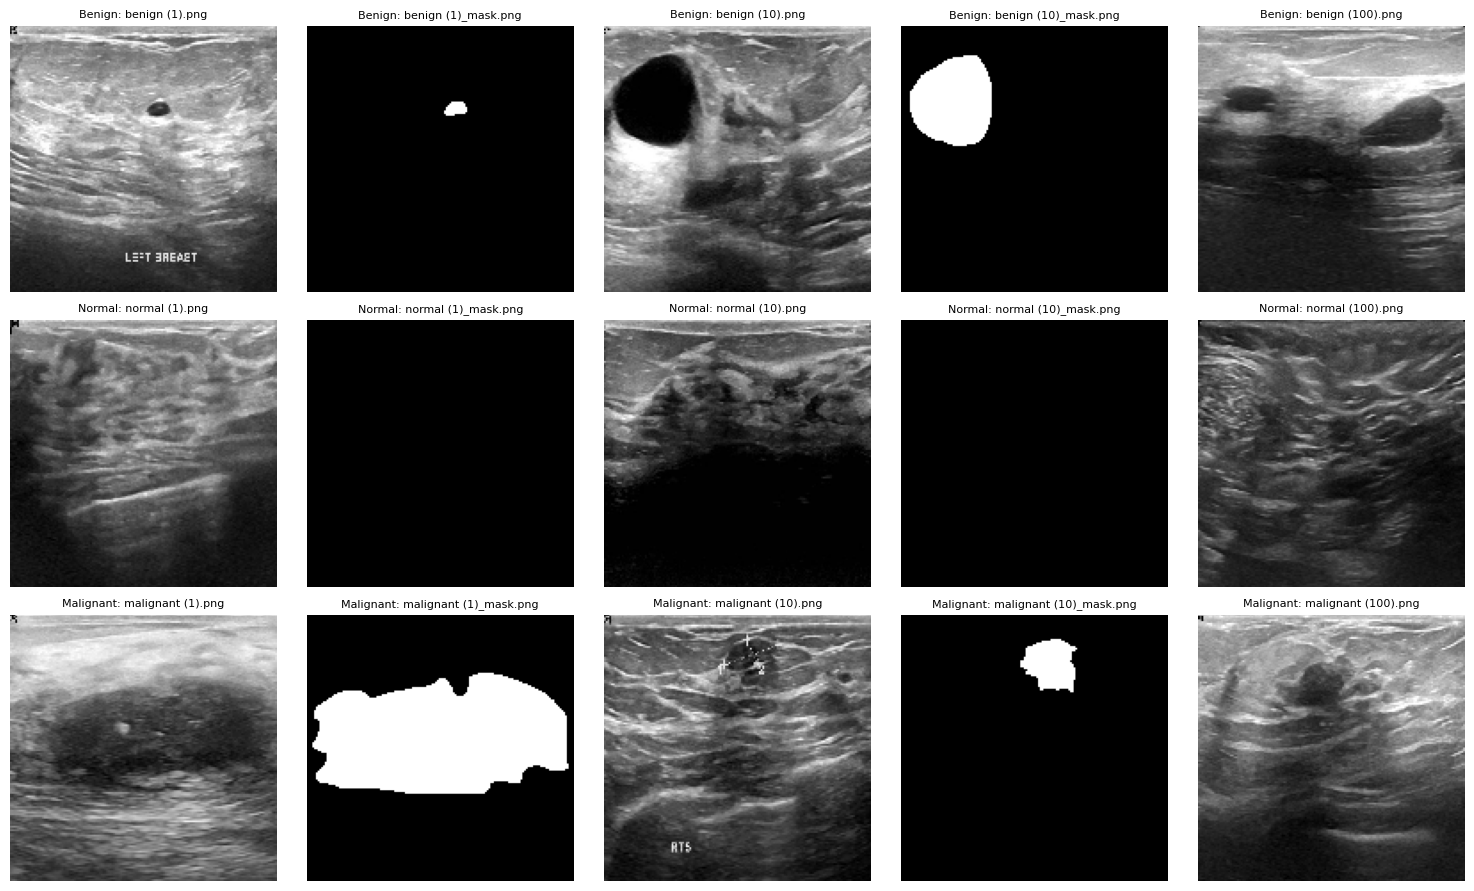

In [9]:
def display_images_with_names(base_dir, categories, num_samples=5):
    fig, axes = plt.subplots(nrows=len(categories), ncols=num_samples, figsize=(num_samples * 3, len(categories) * 3))
    
    for i, category in enumerate(categories):
        category_dir = os.path.join(base_dir, category)
        sample_files = glob.glob(os.path.join(category_dir, '*.png'))[:num_samples]

        for j, file_path in enumerate(sample_files):
            img = load_img(file_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.
            axes[i, j].imshow(img_array)
            axes[i, j].axis('off')
            image_name = os.path.basename(file_path)
            axes[i, j].set_title(f"{category}: {image_name}", fontsize=8)

    plt.tight_layout()
    plt.show()


display_images_with_names(base_dir, categories)

In [3]:
def process_image(img_path):
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array /= 255.  
    return img_array


overlay_images = []
labels = []
for category in categories:
    overlay_dir = os.path.join(base_dir, category, 'overlays')
    for overlay_file in glob.glob(os.path.join(overlay_dir, '*.png')):
        overlay_images.append(process_image(overlay_file))
        labels.append(label_map[category])



In [4]:
overlay_images = np.array(overlay_images)
labels = np.array(labels)

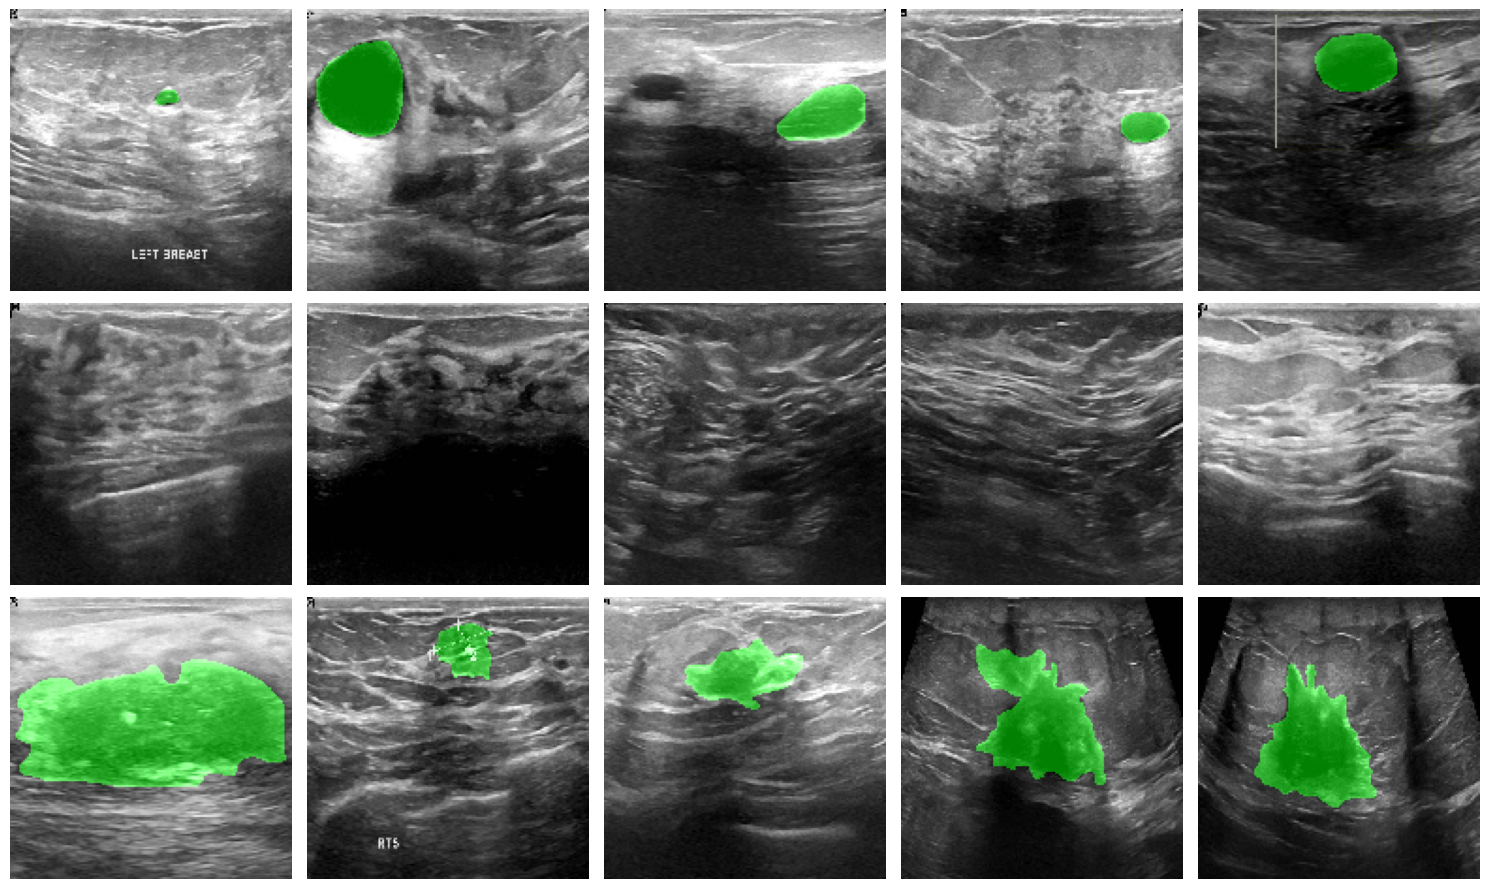

In [10]:
import matplotlib.pyplot as plt

def display_sample_images(image_list, labels, categories, num_samples=5):
    fig, axes = plt.subplots(nrows=len(categories), ncols=num_samples, figsize=(num_samples * 3, len(categories) * 3))
    for i, category in enumerate(categories):
       
        indexes = [idx for idx, label in enumerate(labels) if label == label_map[category]][:num_samples]
        for j, idx in enumerate(indexes):
            axes[i, j].imshow(image_list[idx])
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(category)
    plt.tight_layout()
    plt.show()

display_sample_images(overlay_images, labels, categories)


In [5]:
train_images, test_images, train_labels, test_labels = train_test_split(overlay_images, labels, test_size=0.2, random_state=42)


### CNN

In [7]:
# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator()


In [8]:
# Model definition
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.2),  
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.2),  
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),  
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(3, activation='softmax')
])


model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [10]:
# Prepare generators
batch_size = 32
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size)
early_stopping = EarlyStopping(monitor='val_loss', patience=8)  # Stop if validation loss does not improve after 5 epochs


history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=len(test_images) // batch_size,
    callbacks=[early_stopping]  # Use the correct early stopping variable here

)
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")


Epoch 1/50
19/19 [==============================] - 14s 743ms/step - loss: 0.2762 - accuracy: 0.8936 - val_loss: 0.3877 - val_accuracy: 0.8438
Epoch 2/50
19/19 [==============================] - 13s 672ms/step - loss: 0.3192 - accuracy: 0.8851 - val_loss: 0.3023 - val_accuracy: 0.8984
Epoch 3/50
19/19 [==============================] - 13s 664ms/step - loss: 0.3208 - accuracy: 0.8750 - val_loss: 0.3190 - val_accuracy: 0.8516
Epoch 4/50
19/19 [==============================] - 13s 679ms/step - loss: 0.3469 - accuracy: 0.8818 - val_loss: 0.2919 - val_accuracy: 0.8828
Epoch 5/50
19/19 [==============================] - 13s 678ms/step - loss: 0.2729 - accuracy: 0.9054 - val_loss: 0.2964 - val_accuracy: 0.8750
Epoch 6/50
19/19 [==============================] - 14s 712ms/step - loss: 0.2885 - accuracy: 0.8919 - val_loss: 0.3945 - val_accuracy: 0.8438
Epoch 7/50
19/19 [==============================] - 14s 713ms/step - loss: 0.2882 - accuracy: 0.8868 - val_loss: 0.3760 - val_accuracy: 0.8438

5/5 [==============================] - 1s 104ms/step
              precision    recall  f1-score   support

      Benign       0.80      1.00      0.89        84
      Normal       1.00      1.00      1.00        26
   Malignant       1.00      0.54      0.70        46

    accuracy                           0.87       156
   macro avg       0.93      0.85      0.86       156
weighted avg       0.89      0.87      0.85       156



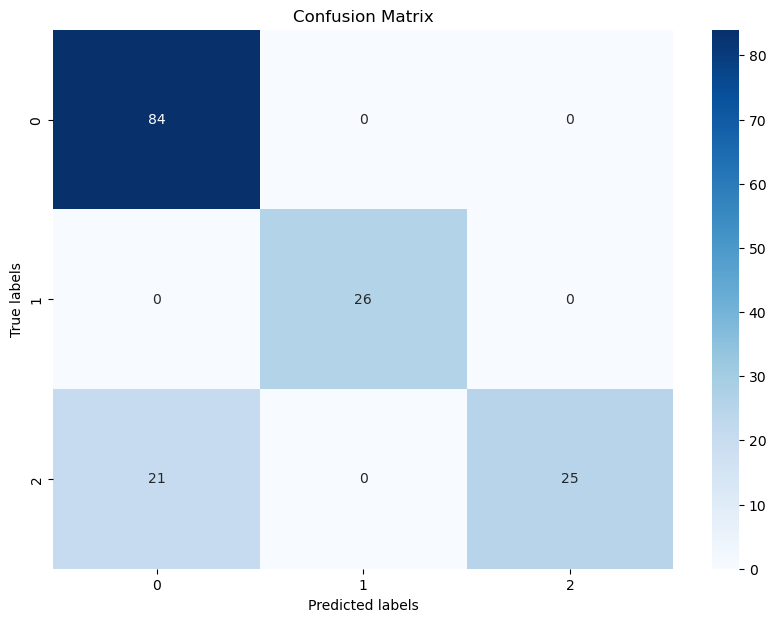

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions on the test set
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate and print classification report
print(classification_report(test_labels, y_pred_classes, target_names=categories))

# Generate and display a confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


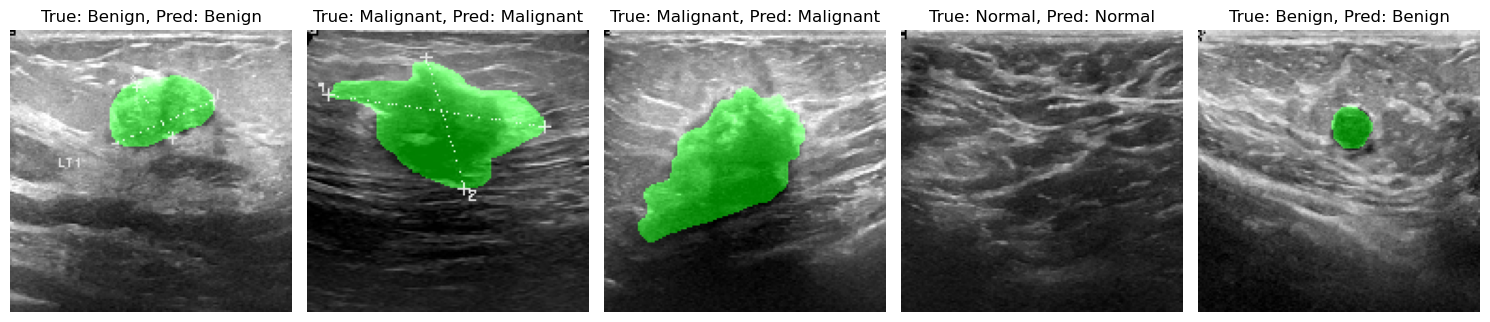

In [18]:
# Optional: Display some test images with their predicted and true labels
num_samples = 5  # Number of samples to display
indices = np.random.choice(range(len(test_images)), num_samples, replace=False)

plt.figure(figsize=(15, 5))
for i, index in enumerate(indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(test_images[index])
    plt.title(f"True: {categories[test_labels[index]]}, Pred: {categories[y_pred_classes[index]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### VGG

In [19]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(2048, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model_1 = Model(inputs=base_model.input, outputs=predictions)

model_1.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [21]:
history_1 = model_1.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=len(test_images) // batch_size,
    callbacks=[early_stopping]  # Use the correct early stopping variable here
)

final_train_accuracy = history_1.history['accuracy'][-1]
final_val_accuracy = history_1.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")


Epoch 1/50
19/19 [==============================] - 29s 2s/step - loss: 0.3013 - accuracy: 0.8851 - val_loss: 0.2809 - val_accuracy: 0.9062
Epoch 2/50
19/19 [==============================] - 30s 2s/step - loss: 0.2700 - accuracy: 0.8986 - val_loss: 0.3947 - val_accuracy: 0.8828
Epoch 3/50
19/19 [==============================] - 30s 2s/step - loss: 0.2119 - accuracy: 0.9257 - val_loss: 0.4089 - val_accuracy: 0.9141
Epoch 4/50
19/19 [==============================] - 30s 2s/step - loss: 0.2906 - accuracy: 0.8885 - val_loss: 0.3965 - val_accuracy: 0.8672
Epoch 5/50
19/19 [==============================] - 30s 2s/step - loss: 0.3699 - accuracy: 0.8750 - val_loss: 0.3631 - val_accuracy: 0.8672
Epoch 6/50
19/19 [==============================] - 30s 2s/step - loss: 0.2442 - accuracy: 0.9037 - val_loss: 0.3422 - val_accuracy: 0.9219
Epoch 7/50
19/19 [==============================] - 30s 2s/step - loss: 0.2991 - accuracy: 0.9088 - val_loss: 0.4055 - val_accuracy: 0.8984
Epoch 8/50
19/19 [==

5/5 [==============================] - 5s 1s/step
              precision    recall  f1-score   support

      Benign       0.94      0.88      0.91        84
      Normal       0.87      1.00      0.93        26
   Malignant       0.85      0.87      0.86        46

    accuracy                           0.90       156
   macro avg       0.88      0.92      0.90       156
weighted avg       0.90      0.90      0.90       156



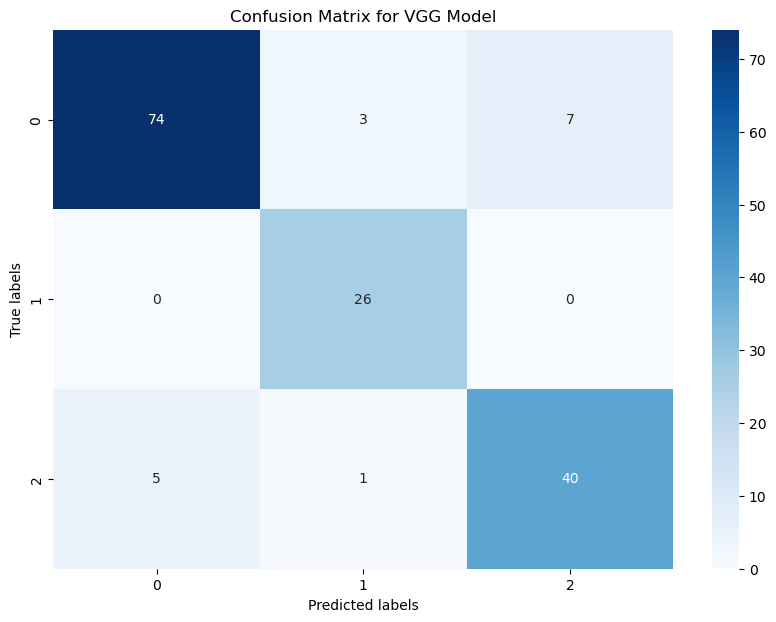

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions on the test set
y_pred_vgg = model_1.predict(test_images)
y_pred_classes_vgg = np.argmax(y_pred_vgg, axis=1)

# Generate and print classification report
print(classification_report(test_labels, y_pred_classes_vgg, target_names=categories))

# Generate and display a confusion matrix
cm_vgg = confusion_matrix(test_labels, y_pred_classes_vgg)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_vgg, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for VGG Model')
plt.show()

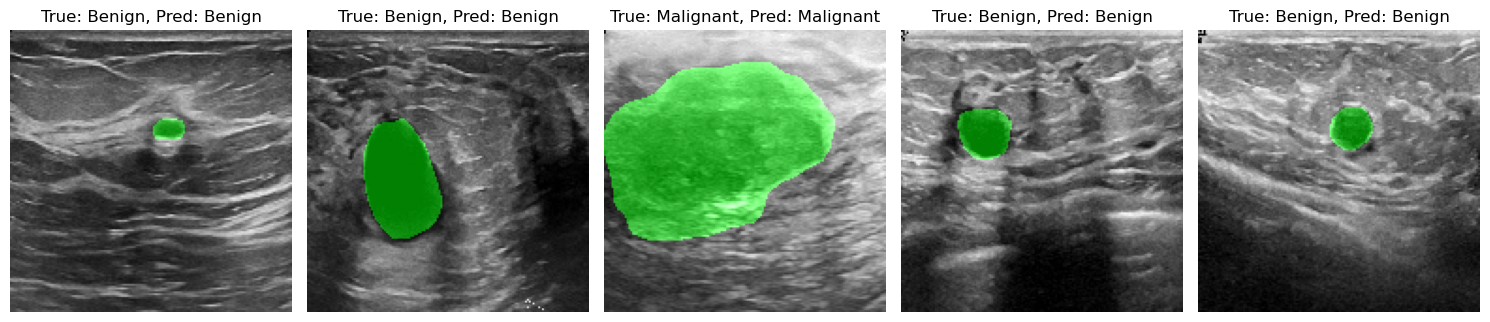

In [24]:
# Optional: Display some test images with their predicted and true labels
num_samples_vgg = 5  # Number of samples to display
indices_vgg = np.random.choice(range(len(test_images)), num_samples_vgg, replace=False)

plt.figure(figsize=(15, 5))
for i, index in enumerate(indices_vgg):
    plt.subplot(1, num_samples_vgg, i + 1)
    plt.imshow(test_images[index])
    plt.title(f"True: {categories[test_labels[index]]}, Pred: {categories[y_pred_classes_vgg[index]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### AlexNet

In [89]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a custom AlexNet-like model
def create_alexnet(input_shape=(150, 150, 3), num_classes=3):
    inputs = Input(shape=input_shape)
    x = Conv2D(128, (3, 3), strides=1, activation='relu')(inputs)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.5)(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.5)(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(256 ,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    return model



In [113]:
# Create the model
model = create_alexnet(input_shape=(150, 150, 3), num_classes=3)

# Unfreeze the top layers of the model
model.trainable = True
fine_tune_at = 35 # Number of layers from the top to fine-tune
for layer in model.layers[:-fine_tune_at]:
    layer.trainable = False


# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Apply data augmentation to the training set
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)


# Recompile the model (this resets the optimizer states)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_65 (Conv2D)          (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 74, 74, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_70 (Dropout)        (None, 74, 74, 128)       0         
                                                                 
 conv2d_66 (Conv2D)          (None, 74, 74, 128)       147584    
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 37, 37, 128)       0         
 ng2D)                                                    

In [114]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8)  # Stop if validation loss does not improve after 5 epochs



# Continue training the model
history_fine = model.fit(
    train_images, train_labels,
    batch_size=25,
    epochs=15,  # You may adjust the number of epochs
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]  # Use the correct early stopping variable here

)
final_val_accuracy = history_fine.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")



Epoch 1/15
25/25 [==============================] - 15s 556ms/step - loss: 2.3635 - accuracy: 0.5096 - val_loss: 1.5838 - val_accuracy: 0.5385
Epoch 2/15
25/25 [==============================] - 14s 550ms/step - loss: 1.4374 - accuracy: 0.5657 - val_loss: 1.4365 - val_accuracy: 0.5385
Epoch 3/15
25/25 [==============================] - 14s 547ms/step - loss: 1.2843 - accuracy: 0.5817 - val_loss: 1.2000 - val_accuracy: 0.6090
Epoch 4/15
25/25 [==============================] - 14s 560ms/step - loss: 1.0312 - accuracy: 0.6298 - val_loss: 0.9961 - val_accuracy: 0.6218
Epoch 5/15
25/25 [==============================] - 14s 552ms/step - loss: 0.9222 - accuracy: 0.6923 - val_loss: 0.9174 - val_accuracy: 0.6795
Epoch 6/15
25/25 [==============================] - 14s 546ms/step - loss: 0.8475 - accuracy: 0.7212 - val_loss: 0.8812 - val_accuracy: 0.7372
Epoch 7/15
25/25 [==============================] - 14s 547ms/step - loss: 0.8112 - accuracy: 0.7019 - val_loss: 0.8193 - val_accuracy: 0.7949

5/5 [==============================] - 1s 129ms/step
              precision    recall  f1-score   support

           0       0.78      0.90      0.84        84
           1       0.93      1.00      0.96        26
           2       0.77      0.50      0.61        46

    accuracy                           0.80       156
   macro avg       0.82      0.80      0.80       156
weighted avg       0.80      0.80      0.79       156



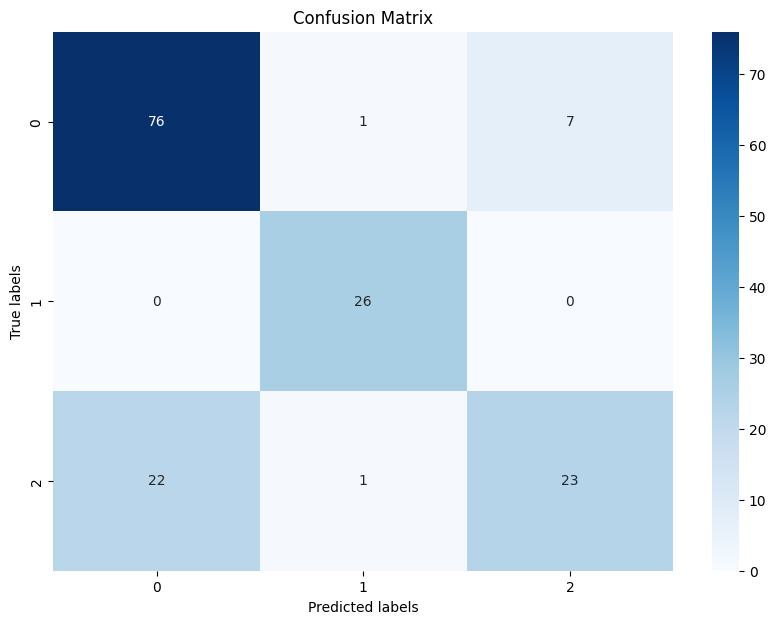

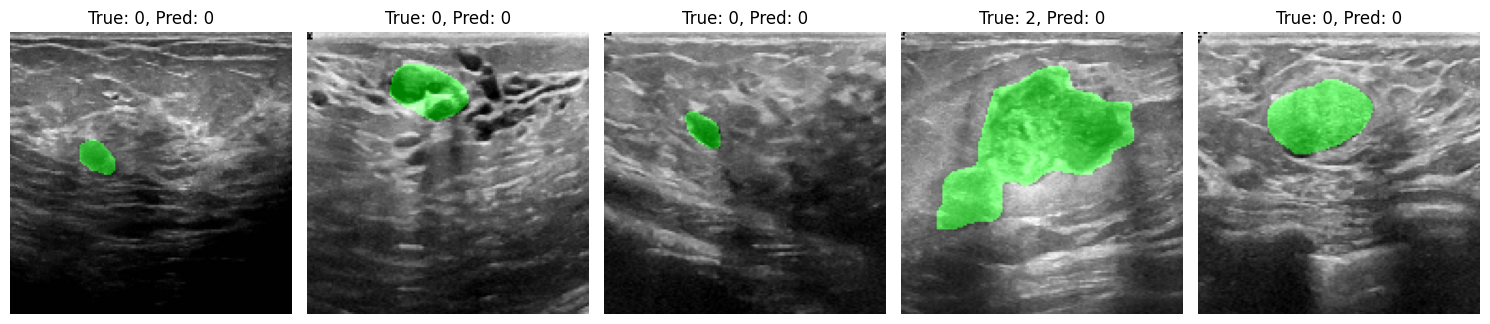

In [115]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate and print classification report
print(classification_report(test_labels, y_pred_classes))

# Generate and display a confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Optional: Display some test images with their predicted and true labels
num_samples = 5  # Number of samples to display
indices = np.random.choice(range(len(test_images)), num_samples, replace=False)

plt.figure(figsize=(15, 5))
for i, index in enumerate(indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(test_images[index])
    plt.title(f"True: {test_labels[index]}, Pred: {y_pred_classes[index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### DenseNet

In [126]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split



base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_map), activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size=25, epochs=10, validation_split=0.01)

loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/10
25/25 [==============================] - 13s 365ms/step - loss: 11.2155 - accuracy: 0.7229 - val_loss: 4.4649 - val_accuracy: 0.8571
Epoch 2/10
25/25 [==============================] - 7s 279ms/step - loss: 1.1911 - accuracy: 0.8995 - val_loss: 3.4411 - val_accuracy: 0.8571
Epoch 3/10
25/25 [==============================] - 7s 288ms/step - loss: 0.5203 - accuracy: 0.9352 - val_loss: 2.8347 - val_accuracy: 0.8571
Epoch 4/10
25/25 [==============================] - 7s 289ms/step - loss: 0.3347 - accuracy: 0.9481 - val_loss: 1.5624 - val_accuracy: 0.8571
Epoch 5/10
25/25 [==============================] - 7s 285ms/step - loss: 0.1533 - accuracy: 0.9579 - val_loss: 1.7513 - val_accuracy: 0.8571
Epoch 6/10
25/25 [==============================] - 7s 271ms/step - loss: 0.0872 - accuracy: 0.9741 - val_loss: 2.1224 - val_accuracy: 0.8571
Epoch 7/10
25/25 [==============================] - 7s 272ms/step - loss: 0.0222 - accuracy: 0.9887 - val_loss: 2.5042 - val_accuracy: 0.8571
Epoc

In [129]:
predicted_labels = model.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)


5/5 [==============================] - 2s 242ms/step


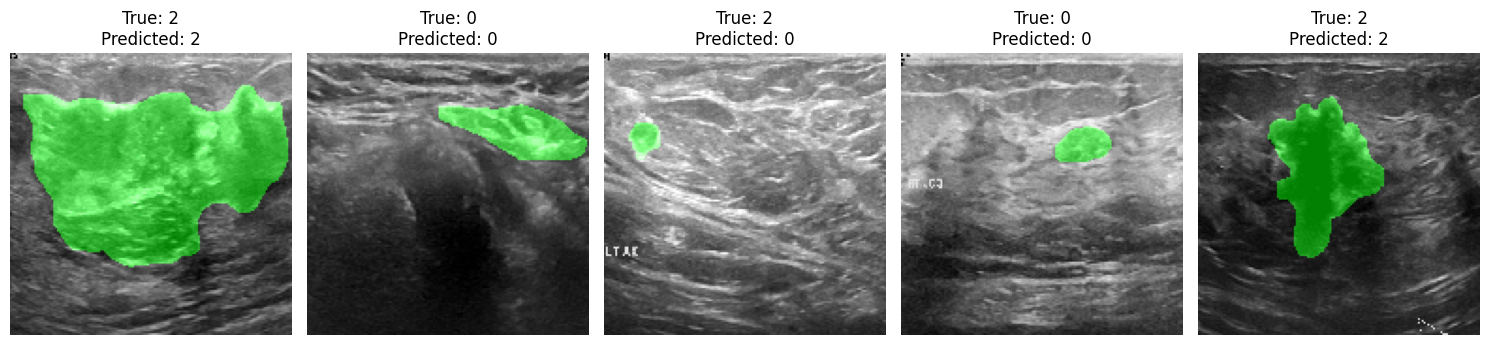

In [130]:
import matplotlib.pyplot as plt
import numpy as np

num_images_to_display = 5  

indices = np.random.choice(range(len(test_images)), num_images_to_display, replace=False)

fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i, idx in enumerate(indices):
    ax = axes[i]
    ax.imshow(test_images[idx])  
    ax.set_title(f"True: {test_labels[idx]}\nPredicted: {predicted_classes[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [131]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(test_labels, predicted_classes))

print("Confusion Matrix:")
cm = confusion_matrix(test_labels, predicted_classes)
print(cm)


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93        84
           1       0.96      1.00      0.98        26
           2       0.95      0.78      0.86        46

    accuracy                           0.92       156
   macro avg       0.93      0.92      0.92       156
weighted avg       0.92      0.92      0.91       156

Confusion Matrix:
[[81  1  2]
 [ 0 26  0]
 [10  0 36]]
